# Ćwiczenie 12 - Algorytm Innowacyjnego Artylerzysty
## Informacje wstępne
Filip Horst 311257

Sprawozdanie w pełni zrealizowane w JupyterNotebook. Wykorzystuje kilka plików lokalnych, które zawierają wykonania grid search, ale wszystko co potrzebne jest już zawarte w output. W badaniu dotarto do ciekawego wniosku, który częściowo obalił badania grid search (są one opisane zgodnie z wnioskami wysnutymi w trakcie ich wykonania) - zalecane jest przejrzenie sekcji nt. zbieżności x do 0 przed wczytywaniem się w szczegóły. 

# Implementacja

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dejong = lambda x: np.sum(x**2)
rastrigin = lambda x: 10*len(x) + np.sum( x**2 - 10 * np.cos(2*np.pi*x) )
rastrigin = lambda x: 10*len(x) + np.sum( np.array(x)**2 - 10 * np.cos(2*np.pi*np.array(x)) )
ackley = lambda x: -20. * np.exp(-1/5 * np.sqrt(1/len(x) * np.sum(np.power(x,2)))) - np.exp(1/len(x) * np.sum(np.cos(2*np.pi*x))) + 20. + np.e

In [3]:
#from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt

def innovative_gunner(obj_func, xmin, xmax, alpha_max = np.pi/2, beta_max = np.pi/2, num_dimensions = 1, num_iterations = 10, popsize = 10, angle_adjuster=None, r=None, coef=None):
    """
    Performs Innovative Gunner Algorithm (AIG) on specified obj_func function:

    Args:
        obj_func: Objective function to minimize
        xmin: Minimum value allowed for x 
        xmax: Maximum value allowed for x
        alpha_max: Controls the allowed value for random alpha angle in angle adjustements: alpha is random <-alpha-max ; alpha_max > with normal distribution where sigma = alpha_max/3
        beta_max: Controls the allowed value for random beta angle in angle adjustements: beta is random <-beta-max ; beta_max > with normal distribution where sigma = beta_max/3
        num_dimensions: Number of objective function dimensions
        num_iterations: Number of iterations = Number of salvos
        popsize: Size of population = Number of gunners
        angle_adjuster: String used to choose angle adjuster. Allowed values 'geometric', 'exponential', 'linear'. Custom can be used by assigning a callable to this parameter. Passed arguments are (angle,iter)
        r: r-value to use in exponential angle adjuster. Defaults to 1/(num_dimentions*num_iterations) if set to None
        coef: decrease coef for geometric angle adjuster. Default 0.97
    """
    
    #Initialize variables
    x = np.empty([popsize,num_dimensions])
    obj_sum_values = []
    obj_min_values = []
    pops = []

    def g(angle):
        angle = np.deg2rad(angle)
        if angle>0:
            return 1/np.cos(angle)
        else:
            return np.cos(angle)

    match angle_adjuster:
        case None:
            def angle_adjuster(angle, iter): return angle
        case 'geometric':
            if (coef==None): coef = 0.97 #decrease coefficient
            def angle_adjuster(angle, iter): return (angle * np.power(coef,iter)) + 1e-100
        case 'exponential':
            if (r==None):
                r = 1/(num_dimensions*num_iterations)
            def angle_adjuster(angle, iter): return (angle * np.exp(-iter*1*r)) + 1e-100
        case 'linear':
            amin = 0 #minimum value for angle
            def angle_adjuster(angle, iter): return (angle + (-iter) * (angle-amin)/num_iterations) + 1e-100
        case _:
            print("WARNING: Using custom defined angle adjuster with parameters (angle, iter)")



    #Random initialization of gun angles
    for i in range(popsize):
        if (num_dimensions > 1):
            for j in range(num_dimensions):
                x[i][j] = xmin + np.random.uniform() * (xmax-xmin)
        else:
            x[i] = xmin + np.random.uniform() * (xmax-xmin)
    pops.append(x.copy())
    
    #First evaluation = observe where shell lands
    y = [obj_func(np.array(x[i])) for i in range(popsize)]
    obj_min = np.min(y)
    obj_minarg = x[np.argmin(y)].copy()

    for iter in range(num_iterations):
        #Modify x = adjust gun angles
        for pos, val in np.ndenumerate(x):
            #Calculate decreased angles
            alpha_dec = angle_adjuster(alpha_max, iter)
            beta_dec = angle_adjuster(beta_max, iter)

            #Get random new angles: normal dist from -alpha_dec to alpha_dec with sigma = alpha_dec/3, where alpha in degrees
            #alpha = truncnorm.rvs((-alpha_dec)/(alpha_dec/3), alpha_dec/(alpha_dec/3), loc=0, scale= alpha_dec/3)
            #beta = truncnorm.rvs((-beta_dec)/(beta_dec/3), beta_dec/(beta_dec/3), loc=0, scale= beta_dec/3)
            
            alpha = np.random.normal(0, alpha_dec/3)
            beta = np.random.normal(0, beta_dec/3)

            #Calculate new value and cut to bounds
            new_val = val * g(alpha) * g(beta)
            if new_val < xmin:
                new_val = xmin
            elif new_val > xmax:
                new_val = xmax
            x[pos] = new_val

        #Evaluate population = fire and observe
        y = [obj_func(np.array(x[i])) for i in range(popsize)]
        iter_obj_min = np.min(y)

        #Save new best results
        if (iter_obj_min < obj_min):
            obj_min = iter_obj_min
            obj_minarg = x[np.argmin(y)].copy()

        #Save data for visualizations
        obj_sum_values.append(np.sum(y))
        obj_min_values.append(obj_min)  
        pops.append(x.copy())
    return obj_minarg, obj_min, obj_sum_values, obj_min_values, pops

# Tester

Po uruchomieniu komórek implementacji algorytm można przetestować na wybranej funkcji używając parametrów i wywołania poniżej. Wykorzystuje tylko numpy i matplotlib, więc nie powinno być większych problemów z zależnościami.

Result 1.1862671210394981e-17 for [-1.35013288e-09 -3.16856630e-09]


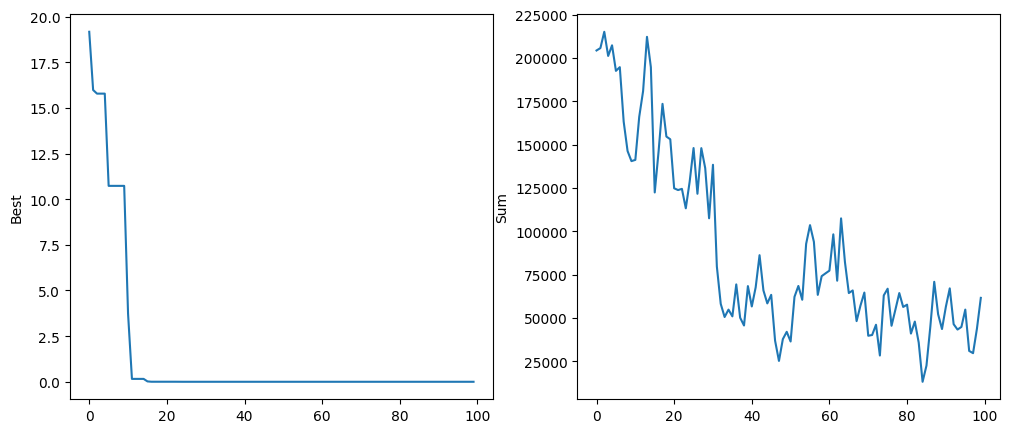

In [118]:
funcs = [dejong, rastrigin, ackley]
lims = [100., 5.12, 32.768]

#Pick test function
id = 0
func = funcs[id]
xmax = lims[id]
xmin = -xmax

#Move function on xaxis
#func = lambda x: funcs[id](x-2)

alpha_max = 180
beta_max = 180

angle_adjuster = 'linear'
angle_adjuster = 'geometric'
coef = 0.99
angle_adjuster = 'exponential'
angle_adjuster = None

ndims = 2
niter = 100
popsize = 30


obj_minarg, obj_min, sum_vals, best_vals, pops = innovative_gunner(func, xmin, xmax, num_dimensions=ndims, num_iterations=niter, popsize=popsize, alpha_max=alpha_max, beta_max=beta_max, angle_adjuster=angle_adjuster, coef=coef)
print(f"Result {obj_min} for {obj_minarg}")

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(best_vals)
axs[1].plot(sum_vals)
axs[0].set_ylabel('Best')
axs[1].set_ylabel('Sum')
plt.show()

# Analiza wpływu parametrów poprzez systematyczne przeszukanie

##  Badane parametry

Zbadane zostały następujące parametry:
* popsize - liczba rozwiązań w populacji
* alpha_max, beta_max - maksymalna wartość kątów aktualizacji
* angle_adjuster - algorytm aktualizacji kąta w zależności od iteracji - None, czyli brak, linear, geometric, bądź exponential. W razie wątpliwości zalecane jest spojrzenie na implementację, ponieważ bez zbędnych komplikacji przedstawia czym są. W sprawozdaniu ten parametr jest często nazywany aktualizatorem.

Stałe były parametry:
* funkcja testująca Rastrigina, zmienna była liczba wymiarów 1 oraz 5 (dostosowywana ręcznie w celu podziału pracy, dlatego kod tylko dla jednej opcji)
* liczba iteracji = 100
* coef = 0.99 - parametr związany z aktualizatorem geometric
* każdy zestaw był przetestowany 3 razy (uwzględnienie losowości)

## Kod i wykonanie przeszukań

In [164]:
funcs = [dejong, rastrigin, ackley]
lims = [100., 5.12, 32.768]

id = 1
func = funcs[id]
xmax = lims[id]
xmin = -xmax
#Move function on xaxis
#func = lambda x: funcs[id](x-2)

#ndims 5 runtime ~7m 30s

rdf = pd.DataFrame(columns=['ndims','niter','popsize','alpha_max','beta_max','angle_adjuster','coef','y'])
coef = 0.99
i = 0
for ndims in [1]:
    for alpha_max in [30, 60, 90, 120, 150, 180]:
        for beta_max in [30, 60, 90, 120, 150, 180]:
            for angle_adjuster in ['linear','geometric','exponential',None]:
                for niter in [100]:
                    for popsize in [20, 50, 100]:
                        for multi in range(3):
                            obj_minarg, obj_min, sum_vals, best_vals, pops = innovative_gunner(func, xmin, xmax, num_dimensions=ndims, num_iterations=niter, popsize=popsize, alpha_max=alpha_max, beta_max=beta_max, angle_adjuster=angle_adjuster, coef=coef)
                            rdf.loc[len(rdf)+1] = [ndims, niter, popsize, alpha_max, beta_max, angle_adjuster, coef, obj_min]
                            rdf.loc[len(rdf)+1] = [ndims, 10, popsize, alpha_max, beta_max, angle_adjuster, coef, best_vals[9]]
                            rdf.loc[len(rdf)+1] = [ndims, 50, popsize, alpha_max, beta_max, angle_adjuster, coef, best_vals[49]]
                            if (i%100 == 0):
                                print(i)
                            i += 1
print(i)
rdf.head(5)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1296


,ndims,niter,popsize,alpha_max,beta_max,angle_adjuster,coef,y
1,1.0,100.0,20.0,30.0,30.0,linear,0.99,0.997410
2,1.0,10.0,20.0,30.0,30.0,linear,0.99,0.997410
3,1.0,50.0,20.0,30.0,30.0,linear,0.99,0.997410
4,1.0,100.0,20.0,30.0,30.0,linear,0.99,0.995093
5,1.0,10.0,20.0,30.0,30.0,linear,0.99,1.409974


In [41]:
if (False):
    rdf.to_csv('./aig_rastra_1.csv')

## Funkcje pomocnicze do analizy

In [123]:
def plot_single(df,param,ax, y='t'):
    #paramdf = df[df[param]!=dflt[param].values[0]].sort_values(by=param)
    #dfltdf = df.loc[[0,1,2]]
    #tdf = pd.concat([paramdf, dfltdf])
    tdf = df.sort_values(by=param)
    try:
        w = max(np.unique(tdf[param]))/30
    except TypeError as e:
        print(e)
        w = 10
    for val in np.unique(tdf[param]):
        tdf2 = tdf[tdf[param] == val]
        ax.boxplot(tdf2[y], positions=[val], widths=[w])

    ax.set_title(f"{param}", fontdict={'fontsize':18})
    ax.set_xlabel("wartosc parametru", fontsize=12)
    ax.set_ylabel(y, labelpad=20, fontsize=18, rotation=0)

    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize=12)

def plot_results(rdf):
    y = 'y'
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    i = -1
    for param in ['niter','popsize','alpha_max','beta_max']:
        i += 1
        axid1 = int(i/2)
        axid2 = i%2
        plot_single(rdf, param, axs[axid1, axid2],y)
        gb = rdf.groupby(by=param)
        gbdf = gb.median(numeric_only=True)[y]
        coef = np.polyfit(gbdf.index, gbdf.values, 1)
        trend = np.poly1d(coef)
        axs[axid1,axid2].plot(gbdf.index, trend(gbdf.index), color='red', label=f'Trend coef: {coef[0]:.5f}')
        axs[axid1,axid2].legend()
    fig.suptitle("Wpływ ustawień na wynik AIG", fontsize=25, y=0.95)
    fig.savefig('./y1.png', bbox_inches='tight')
    
def angle_adjuster_summary_table(rdf):
    
    gb = rdf.groupby(by='angle_adjuster')
    display(gb.agg(['min','mean','median','max'], numeric_only=True)['y'])
def param_summary_table(rdf, param):
    df = pd.DataFrame()
    gb = rdf.groupby(by=param)
    df['param'] = (gb.min(numeric_only=True).index)
    df['min'] = (gb.min(numeric_only=True)['y'].values)
    df['mean'] = (gb.mean(numeric_only=True)['y'].values)
    df['median'] = (gb.median(numeric_only=True)['y'].values)
    df['max'] = (gb.max(numeric_only=True)['y'].values)
    display(df)

# Wyniki dla Rastrigina 1 wymiar

Zawiera opis wyników przeszukania grid search dla f. Rastrigina 1 wymiar

In [124]:
rdf = pd.read_csv('./aig_rastra_1.csv', index_col=0)
rdf['angle_adjuster'] = rdf['angle_adjuster'].replace(np.nan, 'none')

In [121]:
print("Najlepsze wyniki AIG dla Rastrigina 1 wymiar")
rdf.sort_values(by='y').head(5)

Najlepsze wyniki AIG dla Rastrigina 1 wymiar


,ndims,niter,popsize,alpha_max,beta_max,angle_adjuster,coef,y
3847,1.0,100.0,50.0,180.0,180.0,exponential,0.99,0.0
3849,1.0,50.0,50.0,180.0,180.0,exponential,0.99,0.0
3874,1.0,100.0,50.0,180.0,180.0,none,0.99,0.0
3876,1.0,50.0,50.0,180.0,180.0,none,0.99,0.0
3867,1.0,50.0,20.0,180.0,180.0,none,0.99,0.0


Tabela najlepszych wyników niewiele wnosi, bo większość osiągnęła idealny wynik

In [246]:
print("Tabela wartości y dla różnych ustawień alpha_max")
param_summary_table(rdf, 'alpha_max')

Tabela wartości y dla różnych ustawień alpha_max


,param,min,mean,median,max
0,30.0,0.0,0.259563,2.773827e-03,4.010618
1,60.0,0.0,0.226619,2.560234e-03,3.988645
2,90.0,0.0,0.086500,1.961198e-04,1.341434
3,120.0,0.0,0.018346,9.932356e-07,1.043610
4,150.0,0.0,0.001813,6.518359e-09,0.270965
5,180.0,0.0,0.001435,4.182876e-11,0.189817


Alpha_max pod każdym względem zdaje się spełniać zależność "im więcej tym lepiej".

In [247]:
print("Tabela wartości y dla różnych ustawień beta_max")
param_summary_table(rdf, 'beta_max')

Tabela wartości y dla różnych ustawień beta_max


,param,min,mean,median,max
0,30.0,0.0,0.263072,3.497550e-03,4.010618
1,60.0,0.0,0.197954,2.075140e-03,3.988645
2,90.0,0.0,0.109351,1.406826e-04,1.810143
3,120.0,0.0,0.017693,2.222148e-06,1.447063
4,150.0,0.0,0.003654,3.671347e-09,0.419517
5,180.0,0.0,0.002551,6.613554e-11,0.595731


Analogicznie do alpha_max. Jedynym odstępstwem jest niższy max dla ustawienia 150, jednak może to być zasługa losowości.

Charakterystyka funkcji g(kąt) wskazuje na to, że wyższa wartość kąta to wartości bardziej oddalone od 1, czyli większy krok, a zatem w tym problemie algorytm preferuje wykonywać duże kroki.

Pewną hipotezą jest to, że krok zachowuje się podobnie jak współczynnik aktualizacji gradientu w metodach gradientowych, z tą różnicą że stały nie jest sam krok tylko parametry rozkładu normalnego jego losowania. W tym problemie akurat sprawdziło się bardzo wysokie ustawienie, jednak powstaje hipoteza że w innych sytuacjach może powodować to skakanie między zboczami prowadzącymi do optimum, podczas gdy dla mniejszych kątów wartość spada spokojniej po zboczu prowadząc do lepszych wyników.

In [248]:
print("Tabela wartości y dla różnych ustawień alpha_max - analizowane przypadki dla angle_adjuster = None")
tdf = rdf[rdf['angle_adjuster']=='none']
param_summary_table(tdf, 'alpha_max')

Tabela wartości y dla różnych ustawień alpha_max - analizowane przypadki dla angle_adjuster = None


,param,min,mean,median,max
0,30.0,0.0,0.212871,5.956119e-04,2.072302
1,60.0,0.0,0.125089,3.111914e-04,1.447063
2,90.0,0.0,0.065850,1.142752e-06,1.341434
3,120.0,0.0,0.020347,8.036558e-10,1.009351
4,150.0,0.0,0.002941,4.396483e-13,0.204333
5,180.0,0.0,0.001163,1.776357e-15,0.165010


Problem 1-wymiarowy jest na tyle prosty, że nawet bez mechanizmu adaptacji największy krok jest najlepszy.

In [125]:
print("Tabela wartości y dla różnych ustawień popsize")
param_summary_table(rdf, 'popsize')

Tabela wartości y dla różnych ustawień popsize


,param,min,mean,median,max
0,20.0,0.0,0.176774,9.940426e-05,4.010618
1,50.0,0.0,0.073827,2.934606e-06,1.103920
2,100.0,0.0,0.046536,1.689363e-07,1.013335


Popsize również wygląda na "im więcej, tym lepiej". Jest to jednak naturalne, ponieważ więcej prób odgadnięcia = większe prawdopodobieństwo dobrego trafienia.

In [249]:
print("Tabela wartości y dla różnych ustawień popsize")
angle_adjuster_summary_table(rdf)

Tabela wartości y dla różnych ustawień popsize


,min,mean,median,max
angle_adjuster,,,,
exponential,0.0,0.128596,6.594921e-06,4.010618
geometric,0.0,0.093346,8.504416e-06,1.186700
linear,0.0,0.102865,1.108674e-05,1.645193
none,0.0,0.071377,2.936938e-08,2.072302


W tym problemie najlepiej zadiałały aktualizatory exponential oraz wyłączony. Więcej wniosków daje dokładniejsza analiza aktualizatorów dla danych ustawień dodana poniżej.

## Dodatek: podstawowa analiza wpływu optymalizatorów

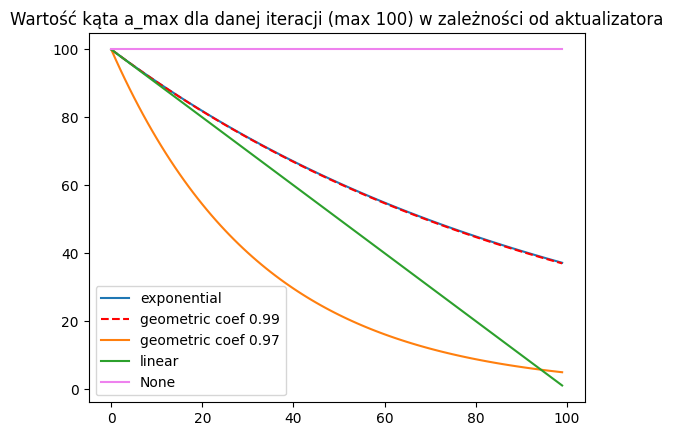

In [263]:
a_max = 100
x = range(100)

r = 1/(1*100)
def angle_adjuster(angle, iter): return (angle * np.exp(-iter*1*r)) + 1e-100
y = [angle_adjuster(a_max, i) for i in x]
plt.plot(x, y, label = 'exponential')

coef = 0.99
def angle_adjuster(angle, iter): return (angle * np.power(coef,iter)) + 1e-100
y = [angle_adjuster(a_max, i) for i in x]
plt.plot(x, y, label = 'geometric coef 0.99', linestyle='--', c='red')

coef = 0.97
def angle_adjuster(angle, iter): return (angle * np.power(coef,iter)) + 1e-100
y = [angle_adjuster(a_max, i) for i in x]
plt.plot(x, y, label = 'geometric coef 0.97')

amin = 0 #minimum value for angle
def angle_adjuster(angle, iter): return (angle + (-iter) * (angle-amin)/100) + 1e-100
y = [angle_adjuster(a_max, i) for i in x]
plt.plot(x, y, label = 'linear')

y = [a_max for i in x]
plt.plot(x, y, label = 'None', c = 'violet')

plt.legend()
plt.title("Wartość kąta a_max dla danej iteracji (max 100) w zależności od aktualizatora")
plt.show()

Co ciekawe, najlepsze aktualizatory, czyli None oraz exponential są zupełnie różne, a osiągają podobne wyniki. Innym zaskoczeniem jest brak obecności ustawienia geometric coef 0.99 w liście najlepszych rozwiązań, ponieważ praktycznie idealnie pokrywa się z exponential (można zauważyć, że trochę zmieniają się dla iteracji >90). Biorąc pod uwagę hipotezy dotyczące kątów jako kroku prawdopodobnie bezpieczniejszym wyborem jest funkcja exponential.

# Wyniki dla Rastrigina 5 wymiarów

In [229]:
rdf = pd.read_csv('./aig_rastra_5.csv', index_col=0)
rdf.sort_values(by='y').head(15)


,ndims,niter,popsize,alpha_max,beta_max,angle_adjuster,coef,y
3742,5.0,100.0,50.0,180.0,150.0,exponential,0.99,3.353762e-12
3643,5.0,100.0,100.0,180.0,120.0,exponential,0.99,2.269473e-11
2461,5.0,100.0,20.0,120.0,150.0,NaN,0.99,2.849276e-11
3226,5.0,100.0,50.0,150.0,180.0,NaN,0.99,6.279777e-11
3016,5.0,100.0,100.0,150.0,120.0,NaN,0.99,1.811884e-10
3121,5.0,100.0,50.0,150.0,150.0,NaN,0.99,2.795844e-10
2473,5.0,100.0,50.0,120.0,150.0,NaN,0.99,3.641105e-10
3235,5.0,100.0,100.0,150.0,180.0,NaN,0.99,3.717417e-10
3208,5.0,100.0,100.0,150.0,180.0,exponential,0.99,4.849028e-10
3211,5.0,100.0,100.0,150.0,180.0,exponential,0.99,5.356000e-10


Już patrząc na zestaw parunastu najlepszych wyników można zauważyć pewne zależności:
* każde ustawienie popsize występuje w tabeli, ale im większy rozmiar tym więcej "przedstawicieli" - odpowiada to wnioskowi, że popsize zwiększa prawdopodobieństwo szczęśliwego trafu
* preferowane b. wysokie alpha i beta max - nawet w tym problemie wyniki są lepsze dla wyższych kroków
* najlepiej zadziałały aktualizatory kąta exponential oraz wyłączony

C:\Users\Filip\AppData\Local\Temp\ipykernel_14208\2036493853.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
C:\Users\Filip\AppData\Local\Temp\ipykernel_14208\2036493853.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
C:\Users\Filip\AppData\Local\Temp\ipykernel_14208\2036493853.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
C:\Users\Filip\AppData\Local\Temp\ipykernel_14208\2036493853.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fonts

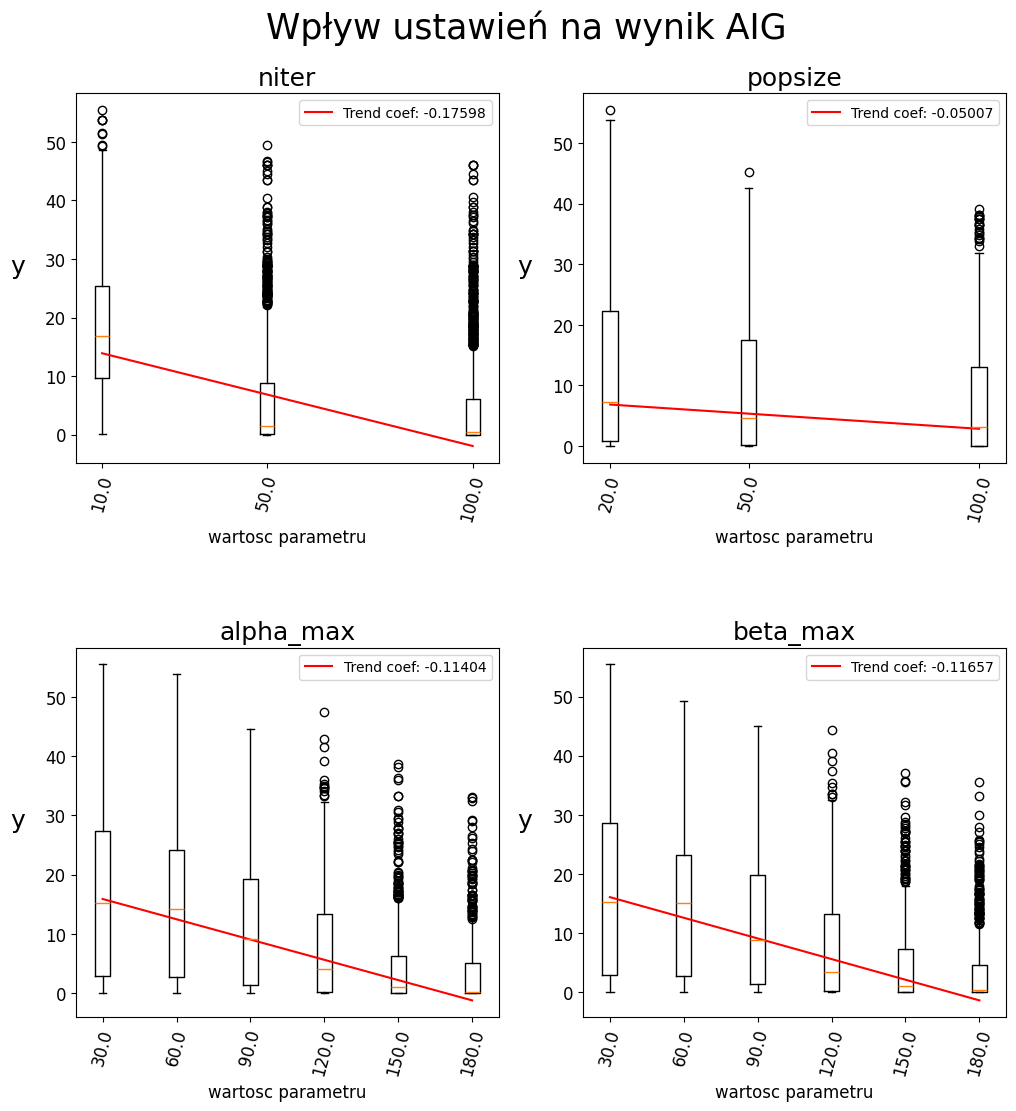

In [231]:
plot_results(rdf)

Wizualizacja potwierdza preferencję wobec wyższych ustawień, która była zauważalna dla problemu 1-wymiarowego.

In [290]:
print("Tabela wartości y dla różnych ustawień popsize")
angle_adjuster_summary_table(rdf)

Tabela wartości y dla różnych ustawień popsize


,min,mean,median,max
angle_adjuster,,,,
exponential,0.0,0.128596,6.594921e-06,4.010618
geometric,0.0,0.093346,8.504416e-06,1.186700
linear,0.0,0.102865,1.108674e-05,1.645193
none,0.0,0.071377,2.936938e-08,2.072302


Wnioski są analogiczne do obserwacji z problemu 1-wymiarowego. Widać jednak, że na ogół algorytm radzi sobie gorzej z tym problemem (zgodnie z oczekiwaniami)

# Dlaczego nie były badane większe alpha_max?

Dodatkowa analiza funkcji g, która prezentuje pewne ograniczenia związane z alpha_max i beta_max

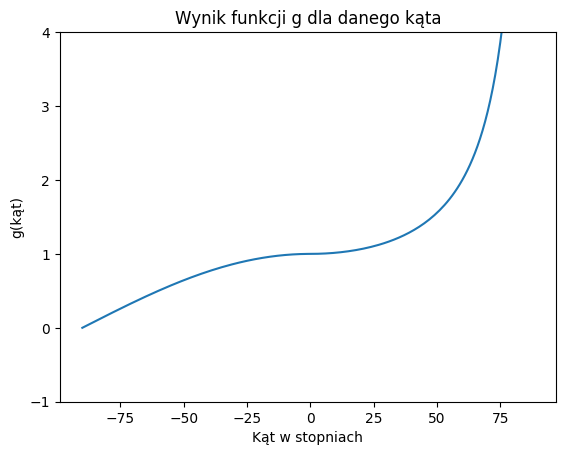

In [10]:
def g(angle):
        angle = np.deg2rad(angle)
        if angle>0:
            return 1/np.cos(angle)
        else:
            return np.cos(angle)

x = range(-90,89)
y = [g(v) for v in x]
plt.plot(x,y)
plt.xlabel("Kąt w stopniach")
plt.ylabel("g(kąt)")
plt.title("Wynik funkcji g dla danego kąta")
plt.ylim([-1,4])
plt.show()

Już od wartości kąta +75 stopni wartość funkcji d zaczyna dynamicznie rosnąć, aż do praktycznie nieskończoności dla 90 stopni. Z tego powodu użycie luźniejszych ograniczeń (większy alpha_max) stwarza większe ryzyko, że losowanie kąta trafi na taką wartość, która spowoduje ogromny krok co raczej zniszczyło by to rozwiązanie. Z tego powodu uznano, że kąt maksymalny 180, co daje losowanie z sigma = 60 i tak jest dostatecznie ryzykowne i dalsze zwiększanie nie ma sensu.

# Porównanie do innych algorytmów

In [127]:
import pandas as pd
def init_df(n):
    columns = ['it','ybest','sum']
    return pd.DataFrame(columns=columns)
def proc_line(df, line, i=0):
    s = line.split(',')
    s.pop()
    #s = [float(x) for x in s]
    try:
        x = [s[0],s[1],s[2]]    
        return x
    except Exception as e:
        pass
def load_log(filename, n):
    with open(filename) as f:
        data = f.readlines()
        df = init_df(n)
        s = [proc_line(df,line, i) for i, line in enumerate(data)]
        
        df['it'] = [x[0] for x in s if x != None]
        df['ybest'] = [x[1] for x in s if x != None]
        df['ycurr'] = [x[2] for x in s if x != None]
        df.drop(df.tail(1).index,inplace=True)
        df = df.astype(float)
    return df

Najlepsze wyniki dla każdego algorytmu:
HS 1.937542e-09
PSO 4.973799e-14
SA 0.04744421
AIG 0 2.3092638912203256e-14
AIG 1 3.163691530971846e-12
AIG 2 7.105427357601002e-15


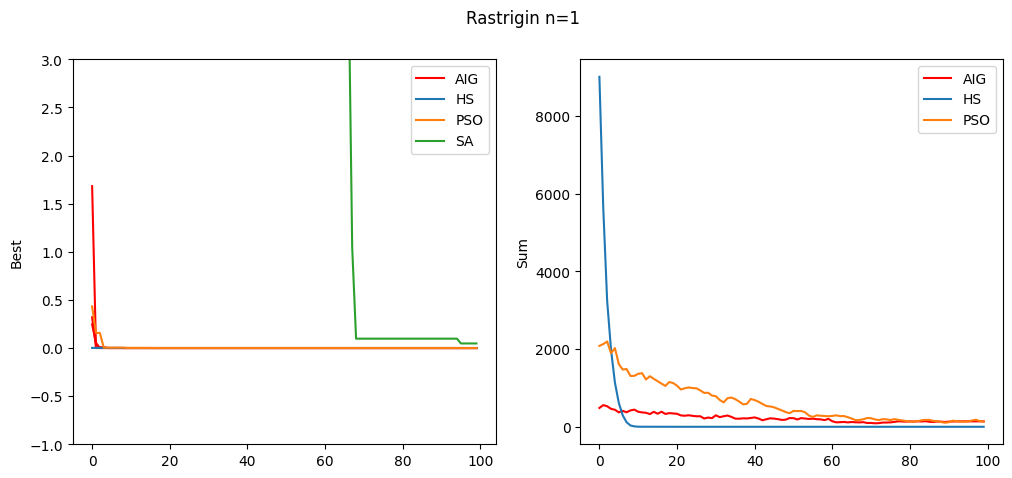

In [130]:
hs1 = load_log('./compare_logs/HS1.txt', 1)
hs1['sum'] = hs1['ycurr']

pso1 = load_log('./compare_logs/PSO1.txt', 1)
pso1['sum'] = pso1['ycurr']

sa1 = load_log('./compare_logs/SA1.txt', 1)

lim = 100

print("Najlepsze wyniki dla każdego algorytmu:")
print('HS', hs1['ybest'][lim-1])
print('PSO', pso1['ybest'][lim-1])
print('SA', sa1['ybest'][lim-1])

fig, axs = plt.subplots(1,2, figsize=(12,5))

labeled = False
for i in range(3):
    obj_minarg, obj_min, sum_vals, best_vals, pops = innovative_gunner(rastrigin, -5.12, 5.12, num_dimensions=1, num_iterations=100, popsize=30, alpha_max=180, beta_max=180, angle_adjuster='linear', coef=coef)
    if labeled:
        axs[0].plot(best_vals, c='red')
    else: 
        axs[0].plot(best_vals, label=f'AIG', c='red')
        labeled = True
    print(f'AIG {i}', best_vals[lim-1])

axs[0].plot(hs1['ybest'][:lim],label='HS')
axs[0].plot(pso1['ybest'][:lim],label='PSO')
axs[0].plot(sa1['ybest'][:lim],label='SA')

axs[1].plot(sum_vals,label='AIG', c='red')
axs[1].plot(hs1['ycurr'][:lim],label='HS')
axs[1].plot(pso1['ycurr'][:lim],label='PSO')

axs[0].legend()
axs[1].legend()
axs[0].set_ylabel('Best')
axs[1].set_ylabel('Sum')

axs[0].set_ylim([-1,3])
fig.suptitle("Rastrigin n=1")
plt.show()

Problem 1 wymiarowego Rastrigina jest zbyt prosty, by dało się porównać algorytmy - wszystkie oprócz naiwnego SA radzą sobie świetnie. Suma wartości f. celu populacji artylerzystów jest słaba w porównaniu do innych i praktycznie stała. Jest to jednak spowodowane tym, że populacja nie jest kooperującą grupą jak w pozostałych tylko bardziej zbiorem indywidualnych jednostek - z tego powodu nie jest ona tak zbieżna.

Najlepsze wyniki dla każdego algorytmu:
HS 1.048089e-06
PSO 0.001072078
SA 78.83042
AIG 0 7.105427357601002e-15
AIG 1 4.499502558985569e-06
AIG 2 4.0676135597550456e-06


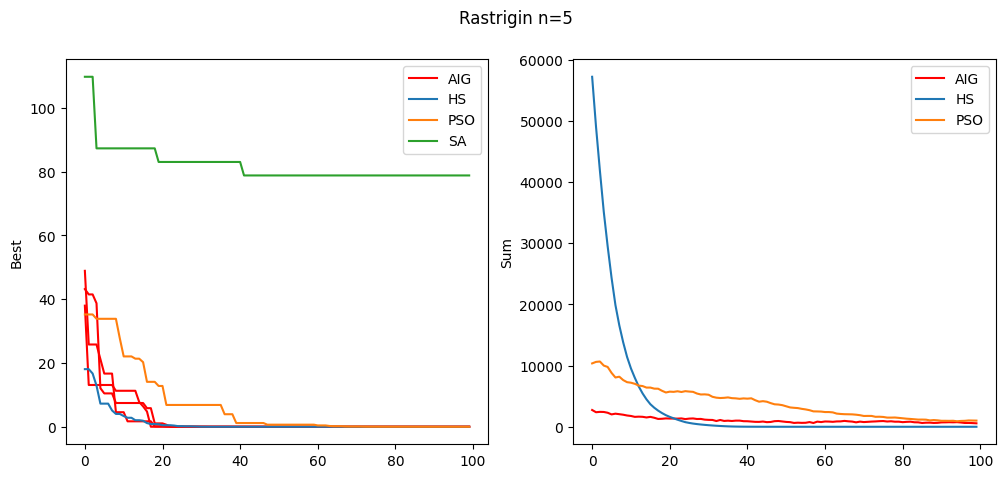

In [131]:
hs1 = load_log('./compare_logs/HS5.txt', 5)
hs1['sum'] = hs1['ycurr']

pso1 = load_log('./compare_logs/PSO5.txt', 5)
pso1['sum'] = pso1['ycurr']

sa1 = load_log('./compare_logs/SA5.txt', 5)

lim = 100

print("Najlepsze wyniki dla każdego algorytmu:")
print('HS', hs1['ybest'][lim-1])
print('PSO', pso1['ybest'][lim-1])
print('SA', sa1['ybest'][lim-1])

fig, axs = plt.subplots(1,2, figsize=(12,5))

labeled = False
for i in range(3):
    obj_minarg, obj_min, sum_vals, best_vals, pops = innovative_gunner(rastrigin, -5.12, 5.12, num_dimensions=5, num_iterations=100, popsize=30, alpha_max=180, beta_max=180, angle_adjuster='exponential', coef=coef)
    if labeled:
        axs[0].plot(best_vals, c='red')
    else:
        axs[0].plot(best_vals, label=f'AIG', c='red')
        labeled = True
    print(f'AIG {i}', best_vals[lim-1])

axs[0].plot(hs1['ybest'][:lim],label='HS')
axs[0].plot(pso1['ybest'][:lim],label='PSO')
axs[0].plot(sa1['ybest'][:lim],label='SA')

axs[1].plot(sum_vals,label='AIG', c='red')
axs[1].plot(hs1['ycurr'][:lim],label='HS')
axs[1].plot(pso1['ycurr'][:lim],label='PSO')

axs[0].legend()
axs[1].legend()
axs[0].set_ylabel('Best')
axs[1].set_ylabel('Sum')
fig.suptitle("Rastrigin n=5")
plt.show()

Dla 5 wymiarowego Rastrigina zauważalna jest szybka zbieżność do rozwiązań - wyniki są lepsze nawet od PSO i HS.

# Zbieżność x do 0 - powód dobrych osiągnięć

W trakcie badań wysoka skuteczność tak prostego algorytmu wydała się podejrzana. Po upewnieniu się, że implementacja jest poprawna i zgodna z wizją twórcy przeprowadzono dodatkowe testy, które pozwoliły zauważyć, że wartości parametrów x wraz z iteracjami dążą do wartości zerowych.  Ten rozdział dokładniej bada potencjalny wpływ tej cechy na wyniki w funkcjach testowych. 

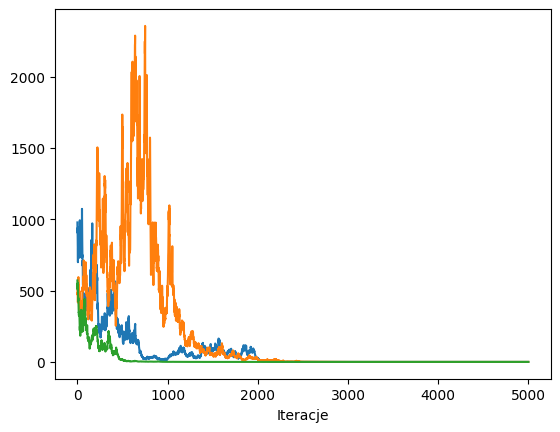

In [132]:
def g(angle):
        angle = np.deg2rad(angle)
        if angle>0:
            return 1/np.cos(angle)
        else:
            return np.cos(angle)

for _ in range(3):
    x = np.random.randint(1000)
    x_hist = [x]
    for _ in range(5000):
        ga = 0.9 + np.random.rand()*0.2
        gb = 0.9 + np.random.rand()*0.2
        x = x * ga * gb
        x_hist.append(x)

    plt.plot(x_hist)
plt.xlabel("Iteracje")
plt.show()

Zgodnie z artykułem twórcy AIG, wartości funkcji g służącej do aktualizacji powinny być bliskie 1. Uwzględniając charakterystykę funkcji g wybrano przedział losowania 0.9 - 1.1 i zasymulowano aktualizację parametru x startującego z wysokiej wartości.

Jak się okazało niezależnie od początkowego ustawienia wartość x silnie dążyła do 0 wraz z iteracjami. To dążenie było mniejsze, bądź większe zależnie od czynników losowych, ale kończyło się to wyzerowaniem. Mogło to mieć wpływ na sukces algorytmu w wielowymiarowym Rastriginie. W celu sprawdzenia tego przeprowadzone zostało dodatkowe badanie z użyciem funkcji przesuniętej na osi X.

In [89]:
def test_1(df, func, ndims, niter=100):
    for i in range(5):
        obj_minarg, obj_min, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=ndims, num_iterations=niter, popsize=30, alpha_max=180, beta_max=180, angle_adjuster='exponential')
        df.loc[len(df)] = [ndims, i, 'Dobrane', obj_minarg,  obj_min]
    for i in range(5):
        obj_minarg2, obj_min2, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=ndims, num_iterations=niter, popsize=30, alpha_max=90, beta_max=90, angle_adjuster=None)
        df.loc[len(df)] = [ndims, i,  'Domyślne', obj_minarg2, obj_min2]
    return df

func1 = lambda x: rastrigin(x-1.12)
func2 = lambda x: np.sum(np.power(x, 4))

In [90]:
pd.set_option('max_colwidth', 1000)
df = pd.DataFrame(columns = ['Wymiary','Próba','Parametry','x','y'])
test_1(df, func1, 1)
test_1(df, func1, 2)
df = test_1(df, func1, 5)

In [91]:
print("Tabela przedstawiająca wyniki testów na przesuniętej o 1.12 na osi x funkcji Rastrigina\n")
df

Tabela przedstawiająca wyniki testów na przesuniętej o 1.12 na osi x funkcji Rastrigina



,Wymiary,Próba,Parametry,x,y
0,1,0,Dobrane,[1.1200587180091084],6.840171e-07
1,1,1,Dobrane,[1.117959719384364],8.258444e-04
2,1,2,Dobrane,[1.1174043706434817],1.336596e-03
3,1,3,Dobrane,[1.1185168085762989],4.364310e-04
4,1,4,Dobrane,[1.1199106232103937],1.584798e-06
5,1,0,Domyślne,[1.1193961762841338],7.233428e-05
6,1,1,Domyślne,[1.1206704671362597],8.918231e-05
7,1,2,Domyślne,[1.1195885269864054],3.358975e-05
8,1,3,Domyślne,[1.1165958735400716],2.298896e-03
9,1,4,Domyślne,[1.118685990167992],3.425462e-04


Powyższa tabela zawiera wyniki optymalizacji. Zadaniem była 1, 2 lub 5-cio wymiarowa funkcja Rastrigina przesunięta o 1.12 w prawo na osi x. Przetestowane zostały dwie wersje parametrów ze 100 iteracjami i populacją 30 - dobrane (kąty max 180, aktualizator exponential) oraz domyślne (kąty 90, brak aktualizacji).

Dla 1 wymiarowego zadania nie ma problemów i AIG radzi sobie bardzo dobrze znajdując punkt blisko optimum.

Niestety dla wielowymiarowych problemów nie jest już tak dobrze. W przypadku 2 wymiarów widać, że najlepsze wyniki mają pewien trend: jeden parametr bliski optimum 1.12, natomiast drugi gdzieś bliżej 0. Jest to potencjalnie spowodowane właśnie dążeniem x do 0. Dla każdego rozwiązania istnieje spora szansa, że kiedy np. x0 osiąga optymalny stan to x1 albo nie zdążyło się jeszcze zbiec w podobne okolice albo już minęło na tyle dużo iteracji, że uciekło w okolice 0. Ta zauważalna wada jest spowodowana brakiem mechanizmu zabezpieczającego przed pogarszaniem się rozwiązań. Jest to zaleta w przypadku minimów lokalnych, jednak może prowadzić do zaobserwowanych tutaj skutków ubocznych.

In [110]:
sdf = pd.DataFrame(columns=['min','mean','median','max'])
gb = df[df['Wymiary']==5].groupby(by='Parametry')
sdf['min'] = gb.min(numeric_only=True)['y'].values
sdf.index = gb.median(numeric_only=True).index
sdf['mean'] = gb.mean(numeric_only=True)['y'].values
sdf['median'] = gb.median(numeric_only=True)['y'].values
sdf['max'] = gb.max(numeric_only=True)['y'].values
print("Statystyki y dla różnych wersji parametrów przy 100 iteracjach - przesunięty Rastrigin")
sdf

Statystyki y dla różnych wersji parametrów przy 100 iteracjach - przesunięty Rastrigin


,min,mean,median,max
Parametry,,,,
Dobrane,9.601060,10.962425,11.421121,12.139046
Domyślne,9.630659,11.667116,11.018089,13.878519


Dodatkowo widać, że ekstremalne wartości kątów ("Dobrane" równe 180) nie są już tak efektywne i domyślne 90 są wystarczające.

## Propozycja poprawy

Wykorzystując obserwację, że nawet dla wielu wymiarów algorytm jest w stanie optymalizować pojedyncze parametry to można wykorzystać ten fakt, by zbudować algorytm krokowy, który stopniowo będzie wybierał kolejne parametry.

In [117]:
#Znajdz x0
func1 = lambda x: rastrigin(np.array([x, 0, 0, 0, 0]) -1.12)
x0, obj_min2, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=1, num_iterations=100
                                                                     , popsize=30, alpha_max=90, beta_max=90, angle_adjuster=None)
#Znajdz x1
func1 = lambda x: rastrigin(np.array([x0, x, 0, 0, 0]) -1.12)
x1, obj_min2, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=1, num_iterations=100
                                                                     , popsize=30, alpha_max=90, beta_max=90, angle_adjuster=None)
#Znajdz x2
func1 = lambda x: rastrigin(np.array([x0, x1, 0, 0, 0]) -1.12)
x2, obj_min2, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=1, num_iterations=100
                                                                     , popsize=30, alpha_max=90, beta_max=90, angle_adjuster=None)
#Znajdz x3
func1 = lambda x: rastrigin(np.array([x0, x1, x2, 0, 0]) -1.12)
x3, obj_min2, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=1, num_iterations=100
                                                                     , popsize=30, alpha_max=90, beta_max=90, angle_adjuster=None)
#Znajdz x4
func1 = lambda x: rastrigin(np.array([x0, x1, x2, x3, x]) -1.12)
x4, obj_min2, sum_vals, best_vals, pops = innovative_gunner(func, -4, 6.24, num_dimensions=1, num_iterations=100
                                                                     , popsize=30, alpha_max=90, beta_max=90, angle_adjuster=None)

#Oblicz wynik
func_test = lambda x: rastrigin(x -1.12)
print(f"Uzyskany wynik: {func_test(np.array([x0,x1,x2,x3,x4]))} dla \nx = [{np.array([x0,x1,x2,x3,x4])}]" )

Uzyskany wynik: 0.010583582540263592 dla 
x = [[[1.11945017]
 [1.11904192]
 [1.12712714]
 [1.12008582]
 [1.12115394]]]


Jak łatwo zauważyć udało się poprawić osiągnięte wyniki - y jest bliski 0 (choć ciągle daleki), a rozwiązanie x przypomina optymalny wektor wartości 1.12.

# Podsumowanie i wnioski końcowe

Parametry AIG mają następujące cechy:
* popsize - jednoznacznie poprawia pracę kosztem wymagań obliczeniowych. Naturalnie w takiej losowej zgadywance więcej prób = większa skuteczność
* niter - liczba iteracji z jednej strony poprawia rozwiązania, ale z drugiej strony jak udowodniło ostatnie badanie powoduje zbliżenie się x do 0, dlatego ustawienie zbyt dużych wartości nie ma sensu
* alpha_max i beta_max - są one pewnego rodzaju krokiem. Zwiększanie ich wartości powoduje większe zmiany parametrów x w iteracjach, co może prowadzić do bardziej dynamicznych skoków. Teoretycznie oznacza to większą eksplorację kosztem eksploatacji, jednak wysoka losowość wyboru alpha i beta sprawiają, że ciężko jednoznacznie stwierdzić, czy to prawda
* angle_adjuster - aktualizacja kątów ma na celu adaptacyjną zmianę kroku jakim są kąty alpha i beta. W przeprowadzonych badaniach nie zauważono większego pozytywnego wpływu aktualizatora na wynik, jednak biorąc pod uwagę wnioski dotyczące dążenia do 0 badania te należało by powtórzyć dla przesuniętych funkcji, gdzie mogło by się okazać, że zwiększają jakość wyników kosztem szybkości poszukiwań zgodnie z teoretycznymi oczekiwaniami

Sam algorytm AIG ma zauważalne cechy:
* innowacyjne podejście z użyciem mnożenia zamiast sumowania do aktualizacji rozwiązania faktycznie jest skuteczne przynajmniej dla funkcji jednowymiarowych. Jest to bardzo ciekawe i należy docenić kreatywność twórcy
* algorytm jest bardzo prosty - brak tutaj jakichkolwiek zależności między artylerzystami w populacji, a przeszukiwanie przestrzeni jest praktycznie całkowicie losowe
* algorytm działa na zasadzie "strzel w losowe miejsce (losowanie populacji początkowej) i przeszukaj okolice (aktualizacje mnożeniem przez wartość bliską 1)". W tym sensie przypomina trochę działanie algorytmu pszczelego, jednak w bardzo uproszczonej formie
* czasami lepiej jest wykonać optymalizację kilka razy zamiast zwiększać liczbę iteracji. Autor wspominał o tym w swoim artykule i faktycznie było to zauważalne w trakcie pracy

Podsumowując, AIG oferuje innowacyjne podejście aktualizacji przez mnożenie, ale w aktualnej implementacji jest zbyt prosty, by realnie konkurować z PSO, czy HS. Ze względu na filozofię "strzel i popraw" podobną do pszczół zwiadowców BA, ciekawym kierunkiem rozwoju byłoby rozbudowanie AIG o mechanizm iteracyjnego losowania nowych rozwiązań i przydzielania danej części populacji do przeszukiwania każdego z nich. Poprzez analogię można by to było wyjaśnić tym, że zwiadowcy wykrywają nowe opancerzone cele i trzeba przydzielić do nich daną liczbę artylerzystów w zależności od ważności celu (np. odległości od bazy, czy pancerza - tylko metafora na wartość f.celu).

Pewnym kierunkiem poprawy byłoby też dokładne przeczytanie artykułu twórcy. Możliwe, że wyjaśnia on ważne zjawisko zbieżności x -> 0 lub udowadnia, że takie coś nie ma miejsca i jest to wada tej konkretnej implementacji.

# Źródła
Do szukania informacji o AIG oprócz instrukcji użyto:
* https://www.tandfonline.com/doi/epdf/10.1080/0305215X.2019.1565282?needAccess=true artykuł twórcy
* http://elektron.pol.lublin.pl/pijarski/aig/AIG_Code.m kod AIG w MatLab - implementacja twórcy